### PCA

With the elbow method, we determine that the number of components is 3.

In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xgboost as xgb

In [22]:
df = pd.read_csv("/content/merged_df.csv")
df

,year-month,gas_value,monthly_ev_sales_with_noise,stock_price_close,stations_number,number_of_licensed_drivers,electricity_price
0,2014-01,3.39200,0.000000,0.000000,5948.0,2.140925e+08,0.134
1,2014-02,3.43425,0.000000,0.000000,6094.0,2.144251e+08,0.134
2,2014-03,3.60580,0.000000,0.000000,6307.0,2.147578e+08,0.135
3,2014-04,3.73525,0.000000,0.000000,6474.0,2.150905e+08,0.131
4,2014-05,3.75000,0.000000,0.000000,6646.0,2.154231e+08,0.136
...,...,...,...,...,...,...,...
124,2024-05,3.72525,3751.709677,66.255455,200997.0,0.000000e+00,0.175
125,2024-06,3.57550,3987.533333,69.565789,204406.0,0.000000e+00,0.178
126,2024-07,3.60040,0.000000,68.798182,207548.0,0.000000e+00,0.178
127,2024-08,3.50650,0.000000,69.747273,212726.0,0.000000e+00,0.177


### XGBoost

In [23]:
# Prepare the data with date filtering
def prepare_data(df):
    # Convert year-month to datetime
    df['date'] = pd.to_datetime(df['year-month'])

    # Filter for dates after 2021-01
    cutoff_date = pd.to_datetime('2021-01')
    df_filtered = df[df['date'] >= cutoff_date].copy()

    # Select features for PCA
    features = ['gas_value', 'stock_price_close', 'stations_number',
                'number_of_licensed_drivers', 'electricity_price']
    X = df_filtered[features]
    y = df_filtered['monthly_ev_sales_with_noise']

    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_scaled)

    return X_pca, y, pca, scaler, df_filtered['date']

# Modified simple backtest function with XGBoost
def simple_backtest(X, y, dates):
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    dates_train, dates_test = dates[:split_idx], dates[split_idx:]

    # Initialize XGBoost regressor
    model = xgb.XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Get training predictions for visualization
    y_train_pred = model.predict(X_train)

    results = evaluate_predictions(y_test, y_pred)

    return {
        'metrics': results,
        'predictions': {
            'train_dates': dates_train,
            'test_dates': dates_test,
            'y_train': y_train,
            'y_test': y_test,
            'y_train_pred': y_train_pred,
            'y_test_pred': y_pred
        }
    }

# Run the analysis
X_pca, y, pca, scaler, dates = prepare_data(df)
results = simple_backtest(X_pca, y, dates)

# Print metrics
print("Train-Test Split Results:")
print(pd.DataFrame([results['metrics']]))


Train-Test Split Results:
          RMSE          MAE       R2
0  1578.396353  1371.177623  0.10382


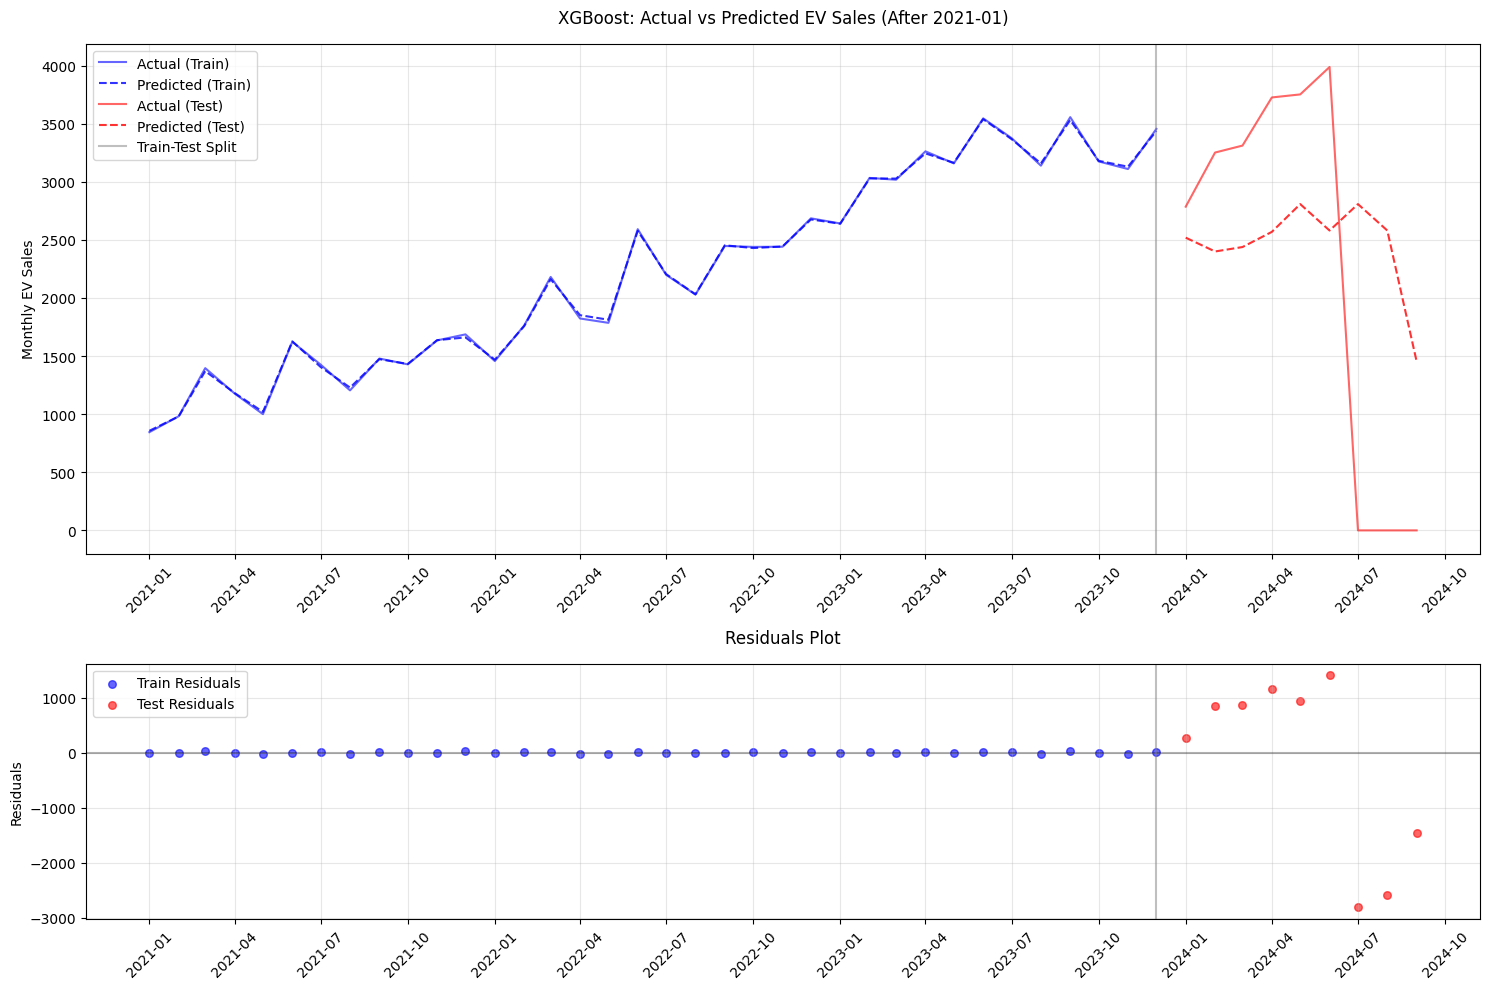


Detailed Metrics:

Training Set:
RMSE: 14.72
R²: 1.00

Test Set:
RMSE: 1578.40
R²: 0.10

Mean Absolute Percentage Error (MAPE) on test set: 25.60%


In [24]:
# Create visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1])

# Extract prediction data
pred_data = results['predictions']

# Plot 1: Actual vs Predicted
ax1.plot(pred_data['train_dates'], pred_data['y_train'],
         label='Actual (Train)', color='blue', alpha=0.6)
ax1.plot(pred_data['train_dates'], pred_data['y_train_pred'],
         label='Predicted (Train)', color='blue', linestyle='--', alpha=0.8)
ax1.plot(pred_data['test_dates'], pred_data['y_test'],
         label='Actual (Test)', color='red', alpha=0.6)
ax1.plot(pred_data['test_dates'], pred_data['y_test_pred'],
         label='Predicted (Test)', color='red', linestyle='--', alpha=0.8)

# Add train-test split line
split_date = pred_data['train_dates'].iloc[-1]
ax1.axvline(x=split_date, color='gray', linestyle='-', alpha=0.5, label='Train-Test Split')

# Configure first plot
ax1.set_title('XGBoost: Actual vs Predicted EV Sales (After 2021-01)', pad=15)
ax1.set_ylabel('Monthly EV Sales')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Format x-axis
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Plot 2: Residuals
train_residuals = pred_data['y_train'] - pred_data['y_train_pred']
test_residuals = pred_data['y_test'] - pred_data['y_test_pred']

ax2.scatter(pred_data['train_dates'], train_residuals,
            label='Train Residuals', alpha=0.6, color='blue', s=30)
ax2.scatter(pred_data['test_dates'], test_residuals,
            label='Test Residuals', alpha=0.6, color='red', s=30)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.axvline(x=split_date, color='gray', linestyle='-', alpha=0.5)

# Configure second plot
ax2.set_title('Residuals Plot', pad=15)
ax2.set_ylabel('Residuals')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Format x-axis
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Additional metrics
train_rmse = np.sqrt(mean_squared_error(pred_data['y_train'], pred_data['y_train_pred']))
train_r2 = r2_score(pred_data['y_train'], pred_data['y_train_pred'])
test_rmse = np.sqrt(mean_squared_error(pred_data['y_test'], pred_data['y_test_pred']))
test_r2 = r2_score(pred_data['y_test'], pred_data['y_test_pred'])

print("\nDetailed Metrics:")
print(f"\nTraining Set:")
print(f"RMSE: {train_rmse:.2f}")
print(f"R²: {train_r2:.2f}")

print(f"\nTest Set:")
print(f"RMSE: {test_rmse:.2f}")
print(f"R²: {test_r2:.2f}")

mape = np.mean(np.abs((pred_data['y_test'] - pred_data['y_test_pred']) /
                      pred_data['y_test'][pred_data['y_test'] != 0])) * 100
print(f"\nMean Absolute Percentage Error (MAPE) on test set: {mape:.2f}%")